In [24]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34, ResNet34_Weights

In [25]:
data_dir = r'./data/'
train_dir = data_dir + r'train/'
valid_dir = data_dir + r'valid/'
test_dir = data_dir + r'test/'

In [26]:
training_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


validation_transforms = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


testing_transforms = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [27]:
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

In [28]:
train_loader = torch.utils.data.DataLoader(training_dataset,batch_size=32,shuffle=True,num_workers=8)
valid_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=32,shuffle=True,num_workers=8)
test_loader = torch.utils.data.DataLoader(testing_dataset,batch_size=32,shuffle=True,num_workers=8)

In [7]:
# ResNet34 모델 불러오기
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

print(model.fc)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=2, bias=True)


In [8]:
import pathlib
root=pathlib.Path(train_dir)
classes=sorted([j.name for j in root.iterdir()])
classes

['not_pizza', 'pizza']

In [29]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
# 2 에폭마다 학습률을 0.1배씩 줄임
exp_lr_scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [11]:
for i, label in test_loader:
    print(i.shape, label.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [102]:
# 에포크 수
n_epochs = 12
# 출력주기
print_every = 10
# 검증 손실 최소값 추적 초기값은 무한대로 설정
valid_loss_min = np.Inf
# 검증 손실 빈 리스트 생성
val_loss = []
# 검증 정확도 빈 리스트 생성
val_acc = []
# 학습 손실 빈 리스트 생성
train_loss = []
# 학습 정확도 빈 리스트 생성
train_acc = []
# 학습 데이터 로더의 총 배치 수
total_step = len(train_loader)

for epoch in range(1, n_epochs+1):
    # 현재 에포크 총 손실 및 정확도 초기화
    running_loss = 0.0
    correct = 0
    total=0
    # 현재 에포크 출력
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        # 배치 데이터 디바이스로 전송
        data_, target_ = data_.to(device), target_.to(device)
        # 그래디언트 0으로 초기화
        optimizer.zero_grad()
        # 현재 배치의 데이터를 모델에 전달하여 출력 계산
        outputs = model(data_)
        # 출력과 타겟 레이블 간의 손실 계산
        loss = criterion(outputs, target_)
        # 역전파 수행
        loss.backward()
        # 모델 가중치 업데이트
        optimizer.step()
        # 에포크 손실 업데이트
        running_loss += loss.item()
        
        _,pred = torch.max(outputs, dim=1) # 예측된 클래스 계산
        correct += torch.sum(pred==target_).item() # 정확한 예측 수 업데이트
        total += target_.size(0) # 처리된 총 데이터 수 업데이트
        
        if (batch_idx) % 20 == 0: # 20 배치마다 현재 손실 출력
            
            # 현재 에포크, 총 에포크, 현재 배치, 총 배치, 현재 손실 출력
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    
    # 에폭의 평균 학습 정확도 계산 및 저장        
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step) # 에폭의 평균 학습 손실 계산 및 저장
    # 에폭의 학습 손실과 정확도 출력
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0 # 검증 손실 초기화
    total_t=0 # 검증 데이터의 총 수 초기화
    correct_t=0 # 검증 데이터의 정확한 예측 수 초기화
    with torch.no_grad(): # 그래디언트 계산 비활성화
        model.eval() # 모델을 평가모드로 설정
        
        # 검증 데이터 로더에서 배치를 순회
        for data_t, target_t in (valid_loader):
            
            # 데이터와 레이블을 계산 디바이스로 이동
            data_t, target_t = data_t.to(device), target_t.to(device)
            # 모델을 통해 예측값 계산
            outputs_t = model(data_t)
            # 손실 계산
            loss_t = criterion(outputs_t, target_t)
            # 검증 손실 업데이트
            batch_loss += loss_t.item()
            # 예측된 클래스 계산
            _,pred_t = torch.max(outputs_t, dim=1)
            # 정확한 예측 수 업데이트
            correct_t += torch.sum(pred_t==target_t).item()
            # 처리된 총 데이터 수 업데이트
            total_t += target_t.size(0)
        # 에폭의 평균 검증 정확도 계산 및 저장
        val_acc.append(100 * correct_t/total_t)
        # 에폭의 평균 검증 손실 계산 및 저장
        val_loss.append(batch_loss/len(valid_loader))
        # 검증 손실이 이전 최소값보다 작은지 확인
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned: # 성능 개선이 감지된 경우
            valid_loss_min = batch_loss # 최소 검증 손실 업데이트
            torch.save(model.state_dict(), 'pizza.pt') # 모델 저장
            print('Improvement-Detected, save-model')
    model.train() # 모델을 학습 모드로 재설정

Epoch 1
Epoch [1/12], Step [0/50], Loss: 0.6611
Epoch [1/12], Step [20/50], Loss: 0.3723
Epoch [1/12], Step [40/50], Loss: 0.4422

train-loss: 0.3926, train-acc: 82.5000
validation loss: 0.1803, validation acc: 93.5000

Improvement-Detected, save-model
Epoch 2
Epoch [2/12], Step [0/50], Loss: 0.1825
Epoch [2/12], Step [20/50], Loss: 0.1328
Epoch [2/12], Step [40/50], Loss: 0.3498

train-loss: 0.3046, train-acc: 91.8125
validation loss: 0.2861, validation acc: 89.0000

Epoch 3
Epoch [3/12], Step [0/50], Loss: 0.2271
Epoch [3/12], Step [20/50], Loss: 0.1076
Epoch [3/12], Step [40/50], Loss: 0.1129

train-loss: 0.2669, train-acc: 92.5625
validation loss: 0.2407, validation acc: 94.0000

Improvement-Detected, save-model
Epoch 4
Epoch [4/12], Step [0/50], Loss: 0.1369
Epoch [4/12], Step [20/50], Loss: 0.1790
Epoch [4/12], Step [40/50], Loss: 0.1814

train-loss: 0.2441, train-acc: 93.0625
validation loss: 0.2140, validation acc: 94.5000

Improvement-Detected, save-model
Epoch 5
Epoch [5/12],

In [17]:
# train_acc, val_acc를 그래프로 그리기 위해 리스트를 넘파이 배열로 변환
import numpy as np

train_acc = np.array(train_acc)
val_acc = np.array(val_acc)
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20, 10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.show()
'''
위에 학습 for문 돌리니 다 돌고 
커널이 죽어서 변수 저장 안 됨
'''

NameError: name 'train_acc' is not defined

In [16]:
def test_accuracy(model, test_loader):

    model.eval()
    model.to(device)

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            images, labels = images.to(device), labels.to(device)
            
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    

In [30]:
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [47]:
# 저장된 모델 불러오기 - 커널 죽어서 모델도 불러와야 했음.
model.load_state_dict(torch.load('pizza.pt'))
# 테스트 정확도 계산
test_accuracy(model, test_loader)

Test Accuracy: 0.9635416865348816


In [11]:
class pizzaCNN(nn.Module):
    def __init__(self):
        super(pizzaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool3(F.relu(self.conv6(x)))
        x = x.view(-1, 256 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# def train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs, patience):
#     early_stopping_counter = 0  # Early Stopping 카운터 초기화
#     best_loss = np.inf  # 최고 손실값 초기화
#     best_model = None  # 최고 모델 초기화
# 
#     for epoch in range(n_epochs):
#         model.train()
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)
# 
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
# 
#             running_loss += loss.item()
# 
#         model.eval()
#         running_corrects = 0
#         valid_loss = 0.0
#         with torch.no_grad():
#             for images, labels in valid_loader:
#                 images = images.to(device)
#                 labels = labels.to(device)
# 
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 valid_loss += loss.item()
#                 _, preds = torch.max(outputs, 1)
#                 running_corrects += torch.sum(preds == labels.data)
# 
#         epoch_acc = running_corrects.double() / len(valid_loader.dataset)
#         valid_loss /= len(valid_loader)
#         print('Epoch: {}/{}\tTraining Loss: {:.4f}\tValidation Loss: {:.4f}\tValidation Acc: {:.4f}'.format(epoch+1, n_epochs, running_loss, valid_loss, epoch_acc))
# 
#         # 검증 손실이 이전의 최고 손실보다 낮은 경우 모델 저장
#         if valid_loss < best_loss:
#             best_loss = valid_loss
#             best_model = model.state_dict()
#             torch.save(best_model, f'{model}.pt')  # 모델 저장
#             early_stopping_counter = 0
#         # 검증 손실이 이전의 최고 손실보다 높거나 같은 경우
#         else:
#             early_stopping_counter += 1
#             print(f'EarlyStopping counter: {early_stopping_counter} out of {patience}')
#             # patience에 도달하면 학습 중단
#             if early_stopping_counter >= patience:
#                 model.load_state_dict(best_model)
#                 return model
# 
#     model.load_state_dict(best_model)
#     return model

In [13]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs, patience):
    early_stopping_counter = 0  # Early Stopping 카운터 초기화
    best_loss = np.inf  # 최고 손실값 초기화
    best_model = None  # 최고 모델 초기화
    
    # 모델의 클래스 이름을 가져와 파일 이름으로 사용
    model_name = model.__class__.__name__
    
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        running_corrects = 0
        valid_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(valid_loader.dataset)
        valid_loss /= len(valid_loader)
        print('Epoch: {}/{}\tTraining Loss: {:.4f}\tValidation Loss: {:.4f}\tValidation Acc: {:.4f}'.format(epoch+1, n_epochs, running_loss, valid_loss, epoch_acc))

                # 검증 손실이 이전의 최고 손실보다 낮은 경우 모델 저장
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = model.state_dict()
            torch.save(best_model, f'{model_name}.pt')  # 모델 저장
            early_stopping_counter = 0
        # 검증 손실이 이전의 최고 손실보다 높거나 같은 경우
        else:
            early_stopping_counter += 1
            print(f'EarlyStopping counter: {early_stopping_counter} out of {patience}')
            # patience에 도달하면 학습 중단
            if early_stopping_counter >= patience:
                model.load_state_dict(best_model)
                return model

    model.load_state_dict(best_model)
    return model

In [14]:
modelp = pizzaCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelp.parameters(), lr=0.001, momentum=0.9)

train_model(modelp, train_loader, valid_loader, criterion, optimizer, n_epochs=20, patience=5)

Epoch: 1/20	Training Loss: 34.6715	Validation Loss: 0.6940	Validation Acc: 0.5000
Epoch: 2/20	Training Loss: 34.6524	Validation Loss: 0.6930	Validation Acc: 0.5000
Epoch: 3/20	Training Loss: 34.6438	Validation Loss: 0.6927	Validation Acc: 0.6550
Epoch: 4/20	Training Loss: 34.6384	Validation Loss: 0.6925	Validation Acc: 0.5850
Epoch: 5/20	Training Loss: 34.6298	Validation Loss: 0.6921	Validation Acc: 0.6800
Epoch: 6/20	Training Loss: 34.6176	Validation Loss: 0.6923	Validation Acc: 0.5350
EarlyStopping counter: 1 out of 5
Epoch: 7/20	Training Loss: 34.6020	Validation Loss: 0.6913	Validation Acc: 0.6650
Epoch: 8/20	Training Loss: 34.5826	Validation Loss: 0.6908	Validation Acc: 0.6350
Epoch: 9/20	Training Loss: 34.5501	Validation Loss: 0.6900	Validation Acc: 0.6900
Epoch: 10/20	Training Loss: 34.4999	Validation Loss: 0.6884	Validation Acc: 0.6050
Epoch: 11/20	Training Loss: 34.4370	Validation Loss: 0.6871	Validation Acc: 0.6750
Epoch: 12/20	Training Loss: 34.3378	Validation Loss: 0.6834	Va

pizzaCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)

In [17]:
test_accuracy(modelp, test_loader)

Test Accuracy: 0.671875


In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 2)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [19]:
modelb = BinaryCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelb.parameters(), lr=0.001, momentum=0.9)

train_model(modelb, train_loader, valid_loader, criterion, optimizer, n_epochs=20, patience=5)

Epoch: 1/20	Training Loss: 33.3159	Validation Loss: 1.0079	Validation Acc: 0.5150
Epoch: 2/20	Training Loss: 29.3288	Validation Loss: 0.6018	Validation Acc: 0.6150
Epoch: 3/20	Training Loss: 28.4427	Validation Loss: 0.5057	Validation Acc: 0.7650
Epoch: 4/20	Training Loss: 27.9814	Validation Loss: 0.4985	Validation Acc: 0.7550
Epoch: 5/20	Training Loss: 26.7331	Validation Loss: 0.3966	Validation Acc: 0.8350
Epoch: 6/20	Training Loss: 24.8078	Validation Loss: 0.3891	Validation Acc: 0.8150
Epoch: 7/20	Training Loss: 23.9682	Validation Loss: 0.4116	Validation Acc: 0.8550
EarlyStopping counter: 1 out of 5
Epoch: 8/20	Training Loss: 23.9390	Validation Loss: 0.5436	Validation Acc: 0.7450
EarlyStopping counter: 2 out of 5
Epoch: 9/20	Training Loss: 24.6305	Validation Loss: 0.3947	Validation Acc: 0.8000
EarlyStopping counter: 3 out of 5
Epoch: 10/20	Training Loss: 24.0588	Validation Loss: 0.4121	Validation Acc: 0.8050
EarlyStopping counter: 4 out of 5
Epoch: 11/20	Training Loss: 23.8852	Validat

BinaryCNN(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

In [20]:
test_accuracy(modelb, test_loader)

Test Accuracy: 0.7395833134651184


In [55]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class BinaryCNN2(nn.Module):
    def __init__(self):
        super(BinaryCNN2, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 1)  # 1개의 출력 노드로 변경

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # 시그모이드로 바꿈
        x = torch.sigmoid(x)
        return x

# 손실 함수 (BCEwithLogitsLoss 사용)
criterion = nn.BCEWithLogitsLoss()

In [59]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs, patience):
    early_stopping_counter = 0  # Early Stopping 카운터 초기화
    best_loss = np.inf  # 최고 손실값 초기화
    best_model = None  # 최고 모델 초기화

    # 모델의 클래스 이름을 가져와 파일 이름으로 사용
    model_name = model.__class__.__name__

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            # 레이블 크기 변환
            labels = labels.unsqueeze(1)

            images = images.to(device)
            labels = labels.to(device).type(torch.float)  # 레이블 타입을 Float으로 변환

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        running_corrects = 0
        valid_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                labels = labels.unsqueeze(1)
                images = images.to(device)
                labels = labels.to(device).type(torch.float)  # 레이블 타입을 Float으로 변환

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(valid_loader.dataset)
        valid_loss /= len(valid_loader)
        print('Epoch: {}/{}\tTraining Loss: {:.4f}\tValidation Loss: {:.4f}\tValidation Acc: {:.4f}'.format(epoch+1, n_epochs, running_loss, valid_loss, epoch_acc))

        # 검증 손실이 이전의 최고 손실보다 낮은 경우 모델 저장
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = model.state_dict()
            torch.save(best_model, f'{model_name}.pt')  # 모델 저장
            early_stopping_counter = 0
        # 검증 손실이 이전의 최고 손실보다 높거나 같은 경우
        else:
            early_stopping_counter += 1
            print(f'EarlyStopping counter: {early_stopping_counter} out of {patience}')
            # patience에 도달하면 학습 중단
            if early_stopping_counter >= patience:
                model.load_state_dict(best_model)
                return model

    model.load_state_dict(best_model)
    return model



In [50]:
for images, labels in train_loader:
    # 레이블 크기 변환
    labels = labels.unsqueeze(1)

In [60]:
modelc = BinaryCNN2().to(device)
optimizer = optim.Adam(modelc.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

train_model(modelc, train_loader, valid_loader, criterion, optimizer, n_epochs=20, patience=5)

Epoch: 1/20	Training Loss: 34.2412	Validation Loss: 0.6920	Validation Acc: 15.7600
Epoch: 2/20	Training Loss: 34.7689	Validation Loss: 0.6931	Validation Acc: 15.5200
EarlyStopping counter: 1 out of 5
Epoch: 3/20	Training Loss: 34.6557	Validation Loss: 0.6931	Validation Acc: 15.2800
EarlyStopping counter: 2 out of 5
Epoch: 4/20	Training Loss: 34.6526	Validation Loss: 0.6930	Validation Acc: 15.5200
EarlyStopping counter: 3 out of 5
Epoch: 5/20	Training Loss: 34.4998	Validation Loss: 0.6922	Validation Acc: 15.5200
EarlyStopping counter: 4 out of 5
Epoch: 6/20	Training Loss: 33.2932	Validation Loss: 0.6313	Validation Acc: 15.6400
Epoch: 7/20	Training Loss: 32.6870	Validation Loss: 0.6395	Validation Acc: 15.4000
EarlyStopping counter: 1 out of 5
Epoch: 8/20	Training Loss: 32.2519	Validation Loss: 0.6164	Validation Acc: 15.7600
Epoch: 9/20	Training Loss: 31.9723	Validation Loss: 0.6590	Validation Acc: 15.4000
EarlyStopping counter: 1 out of 5
Epoch: 10/20	Training Loss: 31.7310	Validation Lo

BinaryCNN2(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [61]:
test_accuracy(modelc, test_loader)

Test Accuracy: 0.522569477558136


In [62]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class BinaryCNN3(nn.Module):
    def __init__(self):
        super(BinaryCNN3, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=3, bias=False) # 커널 5로 바꿈
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 1)  # 1개의 출력 노드로 변경
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # 드롭아웃 추가
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [63]:
modeld = BinaryCNN3().to(device)
optimizer = optim.Adam(modeld.parameters(), lr=0.0001)  # Adam 최적화 사용, 학습률 조정
criterion = nn.BCEWithLogitsLoss()

In [64]:
train_model(modeld, train_loader, valid_loader, criterion, optimizer, n_epochs=20, patience=5)

Epoch: 1/20	Training Loss: 32.5290	Validation Loss: 0.6359	Validation Acc: 15.1600
Epoch: 2/20	Training Loss: 31.7708	Validation Loss: 0.6214	Validation Acc: 15.4000
Epoch: 3/20	Training Loss: 32.0290	Validation Loss: 0.6162	Validation Acc: 15.5200
Epoch: 4/20	Training Loss: 31.6684	Validation Loss: 0.6216	Validation Acc: 15.4000
EarlyStopping counter: 1 out of 5
Epoch: 5/20	Training Loss: 31.1892	Validation Loss: 0.6178	Validation Acc: 15.5200
EarlyStopping counter: 2 out of 5
Epoch: 6/20	Training Loss: 31.0526	Validation Loss: 0.6215	Validation Acc: 15.5200
EarlyStopping counter: 3 out of 5
Epoch: 7/20	Training Loss: 31.2393	Validation Loss: 0.5904	Validation Acc: 15.5200
Epoch: 8/20	Training Loss: 30.9436	Validation Loss: 0.6151	Validation Acc: 15.4000
EarlyStopping counter: 1 out of 5
Epoch: 9/20	Training Loss: 30.7702	Validation Loss: 0.6171	Validation Acc: 15.5200
EarlyStopping counter: 2 out of 5
Epoch: 10/20	Training Loss: 31.1355	Validation Loss: 0.6317	Validation Acc: 15.2800

BinaryCNN3(
  (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [65]:
test_accuracy(modeld, test_loader)

Test Accuracy: 0.4774305522441864


In [66]:
class BinaryCNN4(nn.Module):
    def __init__(self):
        super(BinaryCNN4, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=3, bias=False) # 커널 5로 바꿈
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        # self.layer4 = self._make_layer(512, 3, stride=2)  # layer4 제거
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 1)  # 1개의 출력 노드로 변경, layer4를 제거했으므로 512가 아닌 256을 사용
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)  # layer4 제거
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # 드롭아웃 추가
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [67]:
modele = BinaryCNN4().to(device)
optimizer = optim.Adam(modele.parameters(), lr=0.0001)  # Adam 최적화 사용, 학습률 조정
criterion = nn.BCEWithLogitsLoss()

In [68]:
train_model(modele, train_loader, valid_loader, criterion, optimizer, n_epochs=20, patience=5)

Epoch: 1/20	Training Loss: 32.7692	Validation Loss: 0.6293	Validation Acc: 15.6400
Epoch: 2/20	Training Loss: 31.5496	Validation Loss: 0.6181	Validation Acc: 15.7600
Epoch: 3/20	Training Loss: 31.6484	Validation Loss: 0.6026	Validation Acc: 15.6400
Epoch: 4/20	Training Loss: 31.4233	Validation Loss: 0.6248	Validation Acc: 15.5200
EarlyStopping counter: 1 out of 5
Epoch: 5/20	Training Loss: 31.6320	Validation Loss: 0.6136	Validation Acc: 15.7600
EarlyStopping counter: 2 out of 5
Epoch: 6/20	Training Loss: 31.1327	Validation Loss: 0.6085	Validation Acc: 15.8800
EarlyStopping counter: 3 out of 5
Epoch: 7/20	Training Loss: 31.0706	Validation Loss: 0.6046	Validation Acc: 15.5200
EarlyStopping counter: 4 out of 5
Epoch: 8/20	Training Loss: 30.9555	Validation Loss: 0.5880	Validation Acc: 15.7600
Epoch: 9/20	Training Loss: 30.6541	Validation Loss: 0.6034	Validation Acc: 15.6400
EarlyStopping counter: 1 out of 5
Epoch: 10/20	Training Loss: 30.7848	Validation Loss: 0.5903	Validation Acc: 15.6400

BinaryCNN4(
  (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [69]:
test_accuracy(modele, test_loader)

Test Accuracy: 0.4774305522441864


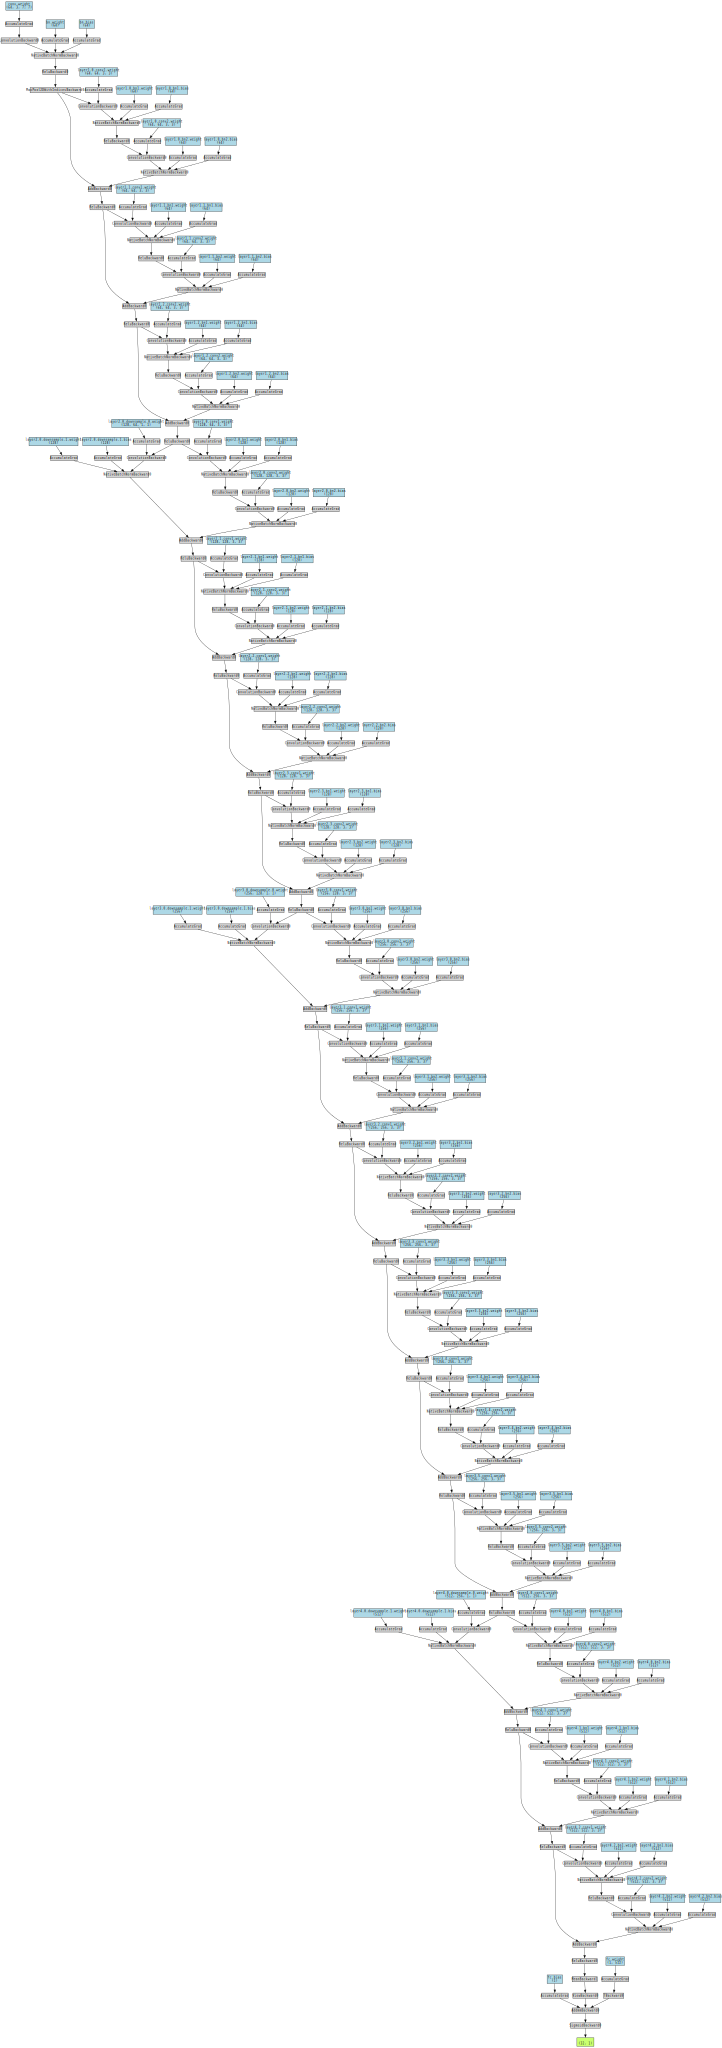

In [70]:
from torchviz import make_dot
make_dot(modelc(images), params=dict(modelc.named_parameters()))

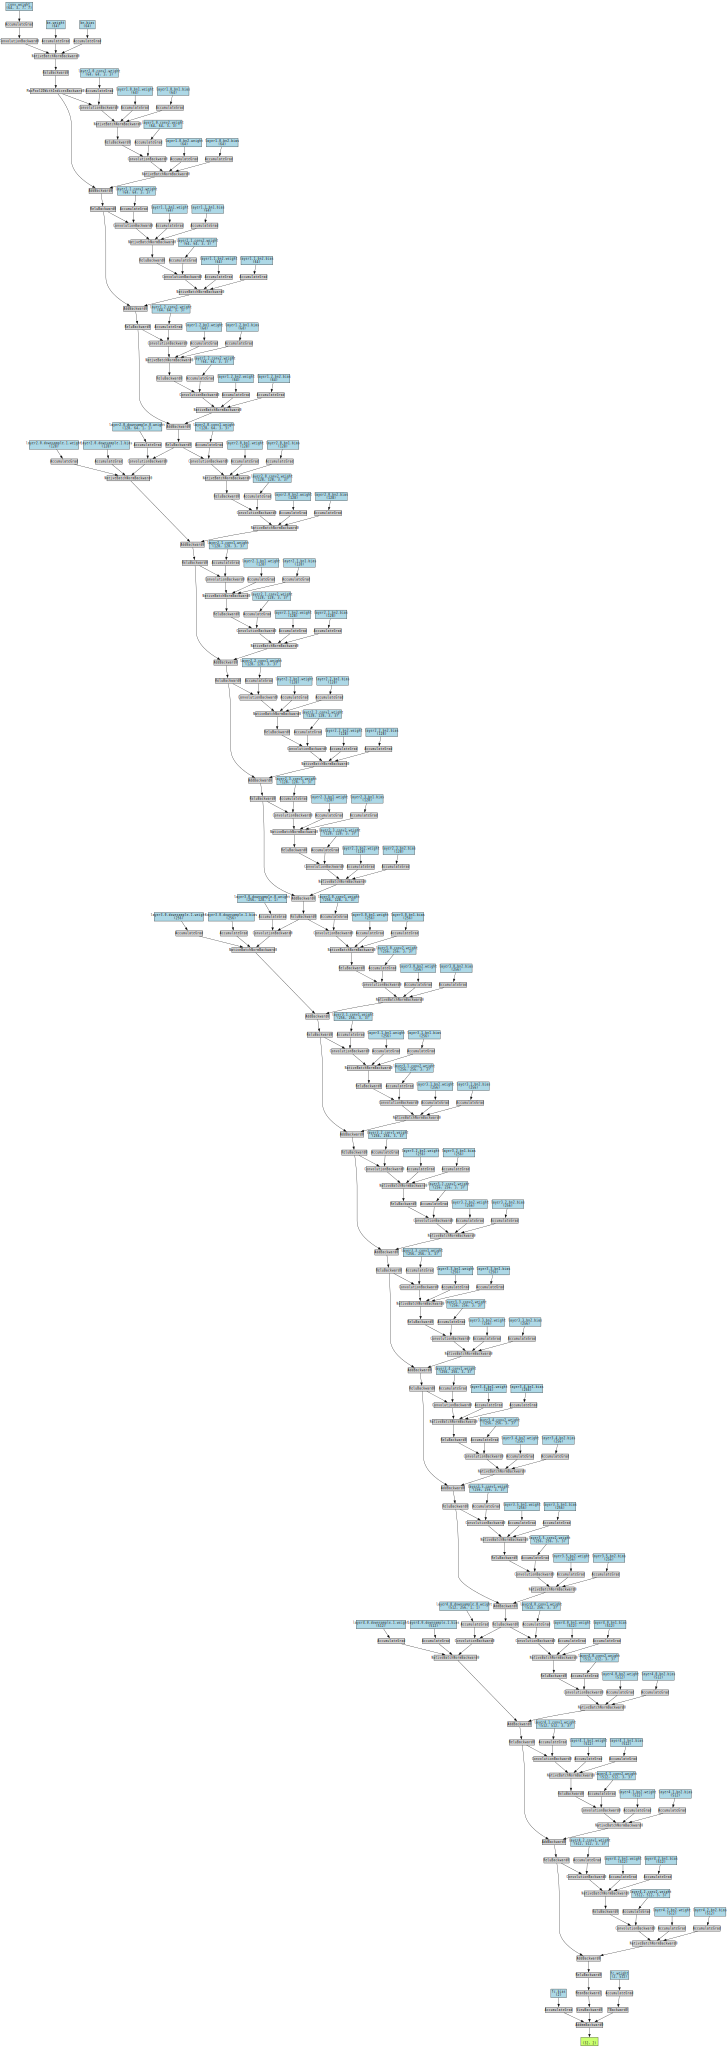

In [71]:
make_dot(modelb(images), params=dict(modelb.named_parameters()))

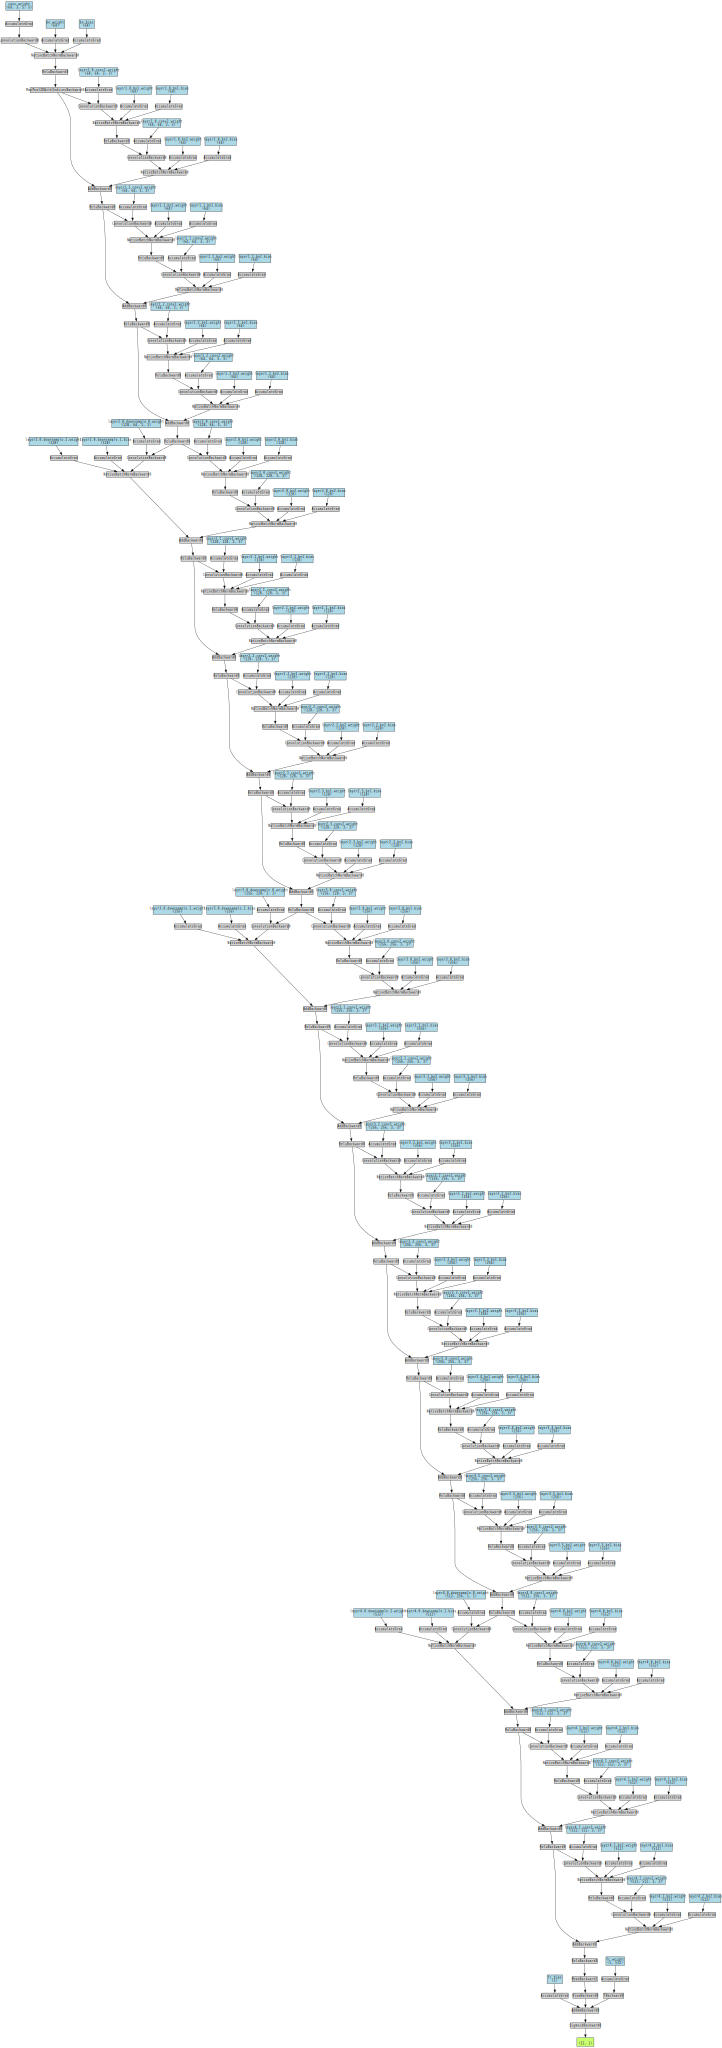

In [72]:
make_dot(modeld(images), params=dict(modeld.named_parameters()))

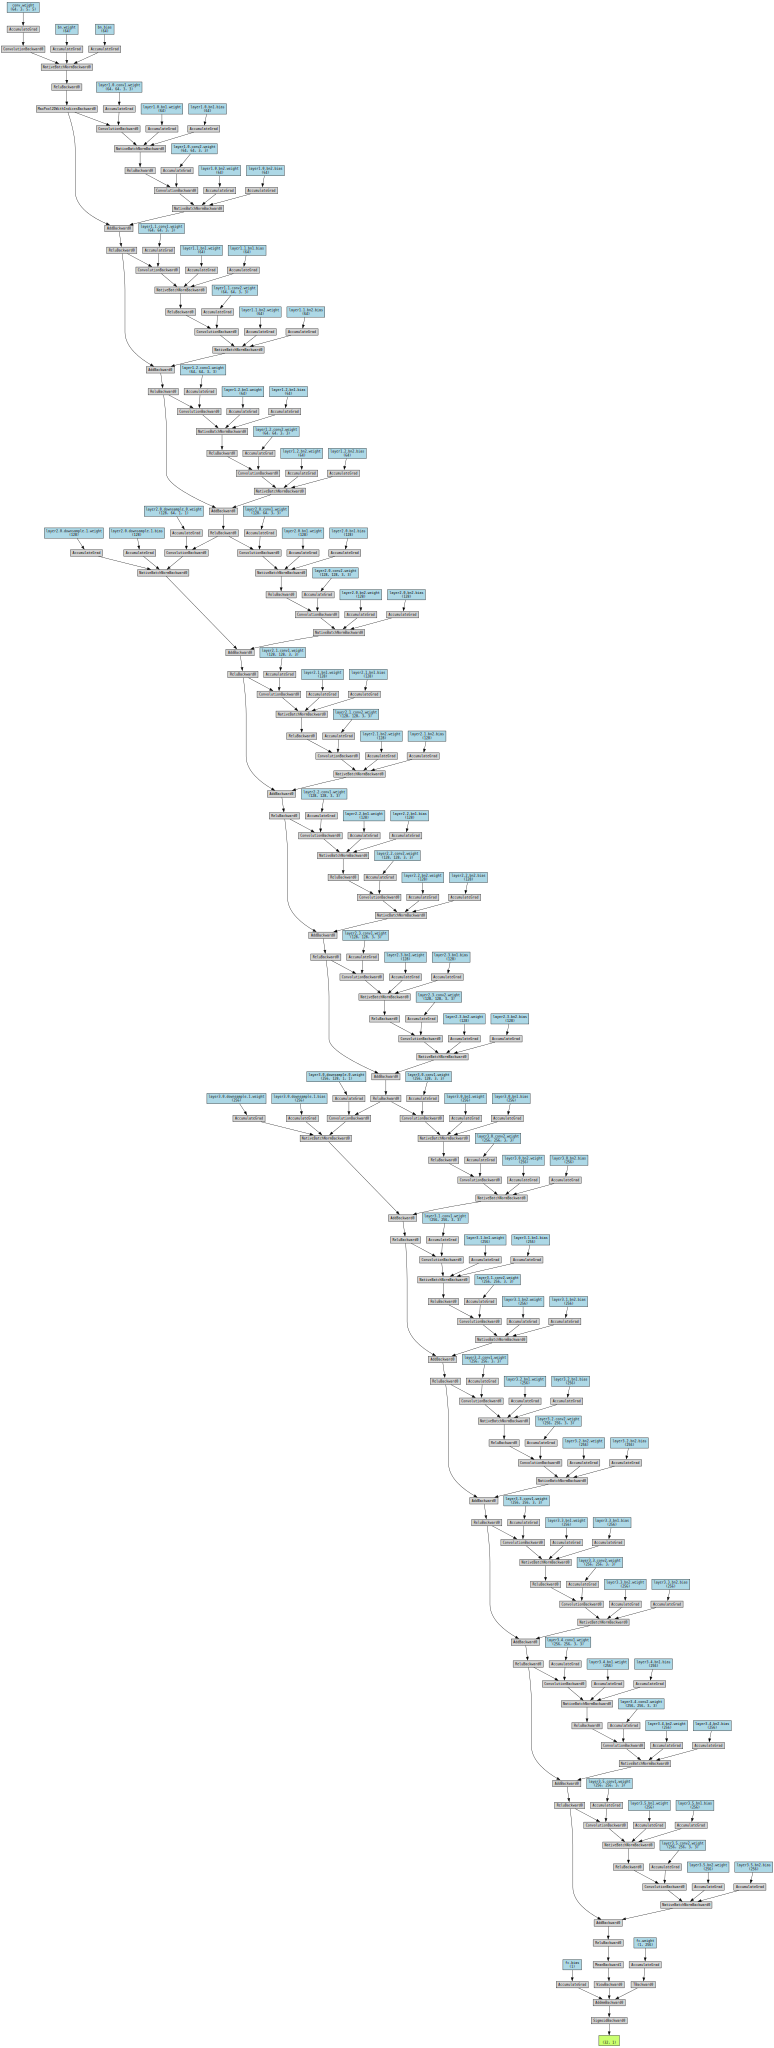

In [73]:
make_dot(modele(images), params=dict(modele.named_parameters()))

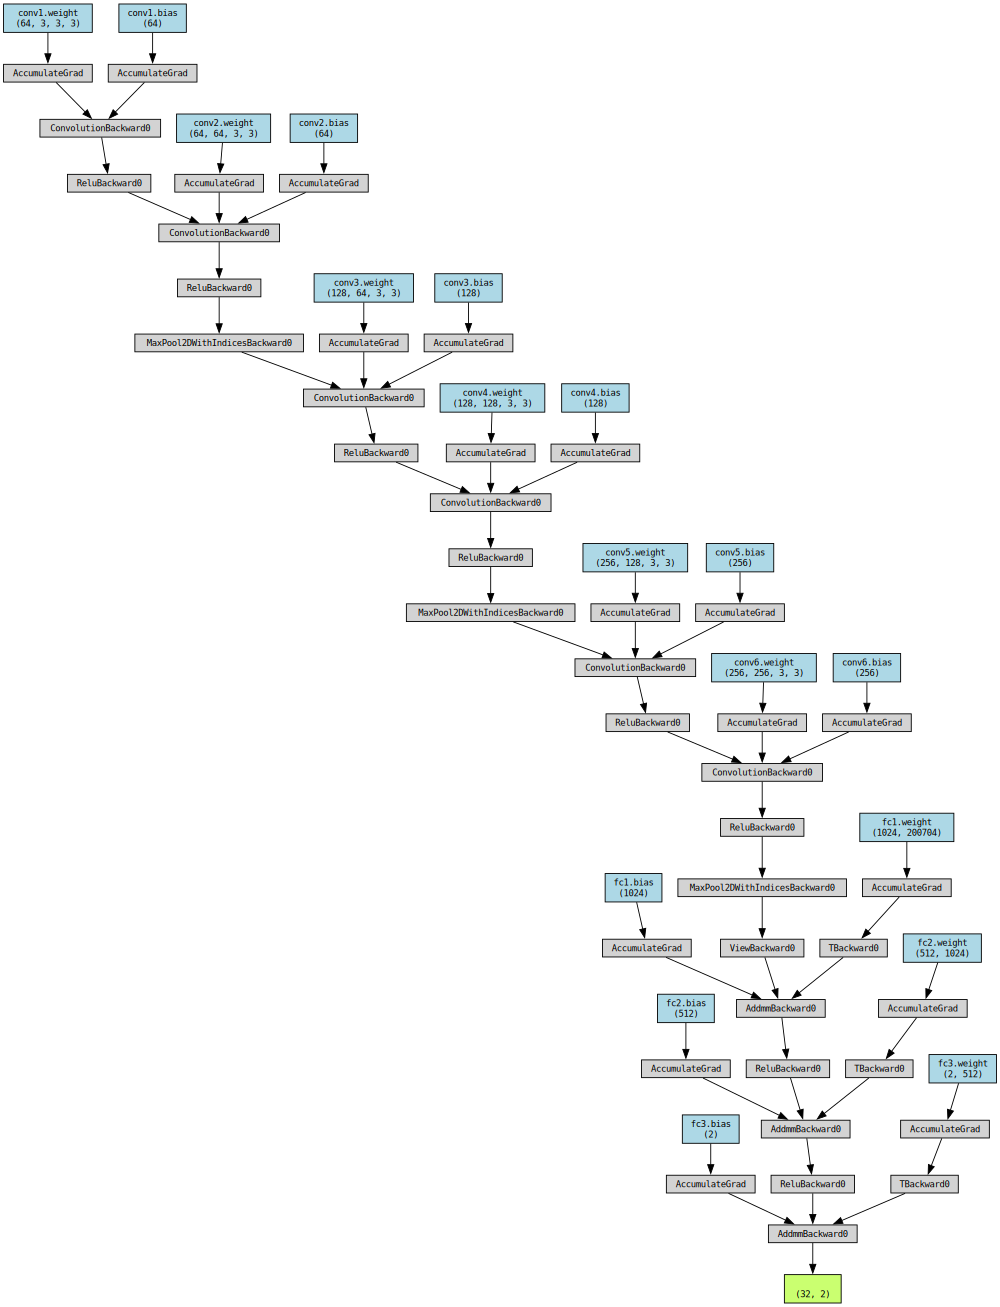

In [74]:
make_dot(modelp(images), params=dict(modelp.named_parameters()))